In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [92]:
import pandas as pd
import numpy as np
import os
import sys
from shutil import copyfile
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator
imagegen = ImageDataGenerator()


In [93]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load train data from drive
disease_types = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Grape___healthy', 'Grape___Leaf_blight', 'Grape___Esca', 'Grape___Black_rot',
    'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'
]

imagegen = ImageDataGenerator()
train_generator = imagegen.flow_from_directory(
    '/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/Mini_SqueezeNet_New/Kodlar/dataset',
    shuffle=False,
    batch_size=64,
    target_size=(224, 224),
    seed=42
)

# Initialize empty lists to store data
x = []
y = []

# Iterate through the generator
for _ in range(train_generator.samples // train_generator.batch_size):
    batch_x, batch_y = next(train_generator)  # Get the next batch
    x.append(batch_x)
    y.append(batch_y)

# Concatenate all batches into a single array
x = np.concatenate(x)
y = np.concatenate(y)

print(x.shape)
print(y.shape)

Found 9385 images belonging to 11 classes.
(9344, 224, 224, 3)
(9344, 11)


In [94]:
#Converting  our color images to a vector
x=x.reshape(9344,224*224*3)

In [95]:
x.shape

(9344, 150528)

In [96]:
#Apply SMOTE method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(x, y)

In [97]:
X_smote.shape

(18095, 150528)

In [98]:
X_smote=X_smote.reshape(18095,224,224,3)

In [99]:
print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {X_smote.shape}''')



Shape of X before SMOTE: (9344, 150528)
Shape of X after SMOTE: (18095, 224, 224, 3)


In [100]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


In [101]:
# Normalize the data
X_smote = X_smote / 255.
print('Train Shape: {}'.format(X_smote.shape))


Train Shape: (18095, 224, 224, 3)


In [102]:
X_train, X_val, Y_train, Y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [103]:
pip install keras_applications

In [104]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '-'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    #x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [105]:
X_train.shape[0:]

(14476, 224, 224, 3)

In [106]:
import tensorflow as tf


# Create the SqueezeNet model
model = SqueezeNet(input_shape=(X_train.shape[1:]), weights=None, classes=Y_train.shape[1], use_bn_on_input=True)

# Set the learning rate
learning_rate = 0.0001

# Initiate Adam optimizer with the correct argument
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Print the model summary
model.summary()

# (Optional) Prepare to train the model and store loss history
loss_history = []


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "squeezenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224, 224, 3)    │             12 │ input_layer_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 111, 111, 64)   │          1,792 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 111, 111, 64)   │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 55, 55, 64)     │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          1,040 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire2-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand1x1      │ (None, 55, 55, 64)     │              0 │ fire2-expand1x1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand3x3      │ (None, 55, 55, 64)     │              0 │ fire2-expand3x3[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-concat              │ (None, 55, 55, 128)    │              0 │ fire2-relu_expand1x1[… │
│ (Concatenate)             │                        │                │ fire2-relu_expand3x3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          2,064 │ fire2-concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire3-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire3-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire3-relu_squeeze1x1… │
├──────────────────────

 Total params: 530,967 (2.03 MB)

 Trainable params: 530,961 (2.03 MB)

 Non-trainable params: 6 (24.00 B)

In [107]:
EPOCHS = 150
BATCH_SIZE=64
SIZE=224
N_ch=3

In [108]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [109]:
hist=model.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1467 - loss: 2.2825
Epoch 1: val_accuracy improved from -inf to 0.15999, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.1469 - loss: 2.2819 - val_accuracy: 0.1600 - val_loss: 2.1804
Epoch 2/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3059 - loss: 1.8133
Epoch 2: val_accuracy improved from 0.15999 to 0.44183, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3061 - loss: 1.8128 - val_accuracy: 0.4418 - val_loss: 1.5175
Epoch 3/150
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4490 - loss: 1.4789
Epoch 3: val_accuracy improved from 0.44183 to 0.56038, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4493 - loss: 1.4781 - val_accuracy: 0.5604 - val_loss: 1.2527
Epoch 4/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5923 - loss: 1.1593
Epoch 4: val_accuracy improve

In [110]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [111]:
y_pred = saved_model.predict(X_val)

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [112]:
y_pred=np.argmax(y_pred, axis=1)

In [113]:
Y_val=np.argmax(Y_val, axis=1)

In [114]:
print("SquezeNet MODEL SONUÇLARI")
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

SquezeNet MODEL SONUÇLARI
Doğruluk:  0.9969604863221885
F1_Skor:  0.9969964518859957
Hassasiyet:  0.9969937797672198
Duyarlılık:  0.99701658041579


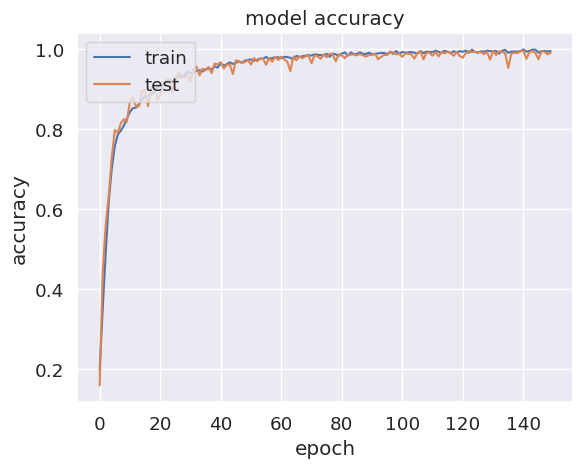

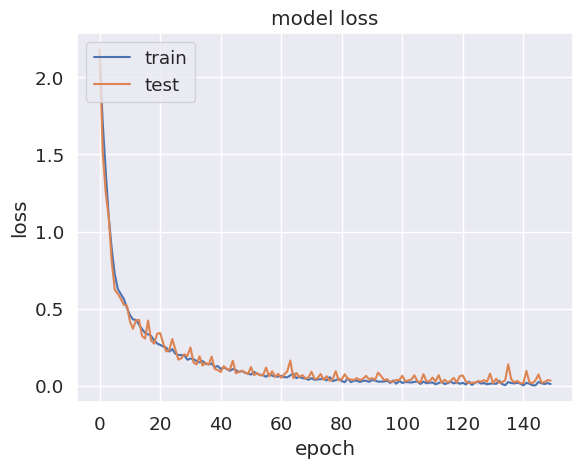

In [115]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[349   0   1   0   0   0   0   0   0   1   0]
 [  1 314   0   0   0   0   0   0   0   0   0]
 [  0   0 339   0   0   0   0   0   0   0   0]
 [  1   0   0 329   0   0   0   0   0   0   0]
 [  0   0   0   0 321   0   1   0   0   0   0]
 [  0   0   0   0   4 329   0   0   0   0   0]
 [  0   0   0   0   0   0 328   0   0   0   0]
 [  0   0   0   0   0   0   0 301   0   0   0]
 [  0   0   0   0   0   0   2   0 343   0   0]
 [  0   0   0   0   0   0   0   0   0 326   0]
 [  0   0   0   0   0   0   0   0   0   0 329]]


<Axes: >

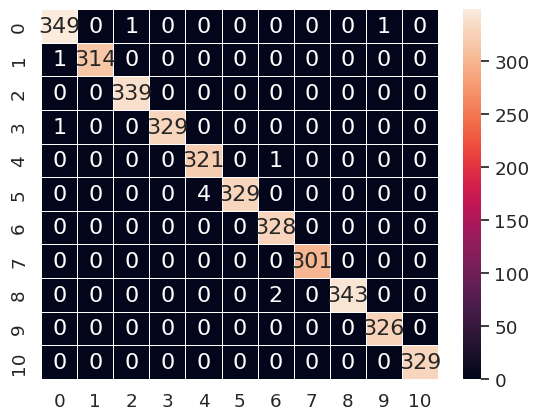

In [116]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size